# 第3章：多层感知机与前向传播

> **学习目标**
> - 理解多层神经网络的结构和设计原理
> - 掌握前向传播的数学推导和实现
> - 理解隐藏层如何进行特征学习
> - 掌握权重初始化的重要性和方法
> - 从零实现一个完整的MLP前向传播

---

## 📚 本章内容

1. **从单层到多层**：为什么需要多层网络？
2. **MLP结构**：输入层、隐藏层、输出层
3. **前向传播数学**：矩阵形式的前向传播
4. **从零实现MLP**：用NumPy构建多层网络
5. **权重初始化**：Xavier、He初始化
6. **特征可视化**：隐藏层学到了什么？
7. **实战项目**：月亮数据集分类
8. **练习题**

---

In [3]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子
np.random.seed(42)

## 1. 为什么需要多层网络？

### 1.1 单层网络的局限性

回顾第1章，我们知道：
- **感知机**只能解决**线性可分**问题（如AND、OR）
- **单层网络**即使加上非线性激活函数，本质上仍是在原始特征空间画一条线/面
- 无法解决**非线性可分**问题（如XOR、复杂的数据分布）

### 1.2 多层网络的核心思想

**关键洞察**：增加隐藏层 = 自动学习特征变换

```
单层网络:
输入 X → [线性变换] → 激活函数 → 输出
        无法改变特征空间

多层网络:
输入 X → [隐藏层1] → [隐藏层2] → ... → 输出
         ↓           ↓
      特征变换1    特征变换2
      
每个隐藏层将数据投影到新的特征空间，
使得最后在新空间中线性可分！
```

### 1.3 直观例子：XOR问题的解决

让我们回顾XOR问题，并看看多层网络如何解决：

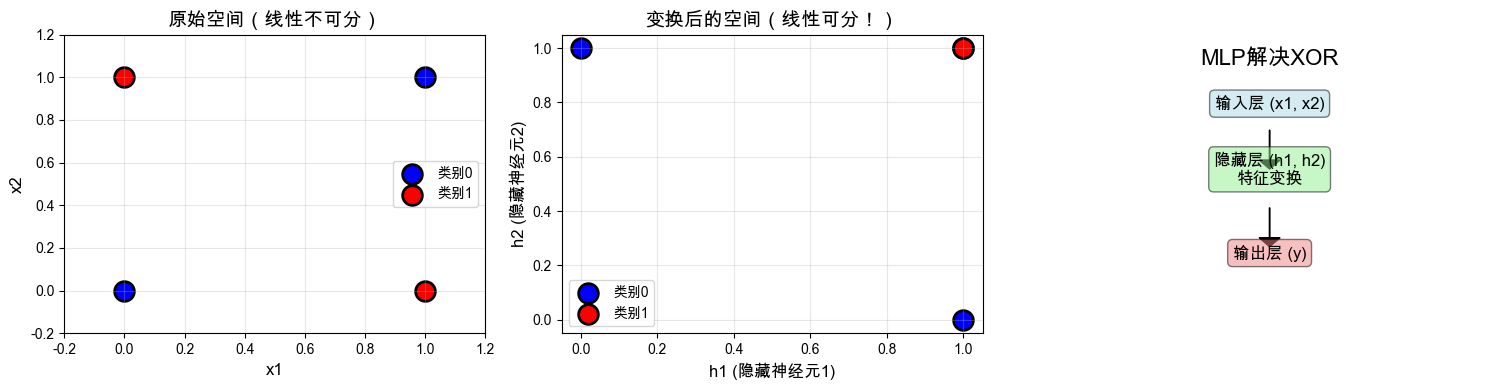


隐藏层输出：
输入 [x1, x2] → 隐藏层 [h1, h2] → 标签
[0 0] → [0.000, 1.000] → 0
[0 1] → [1.000, 1.000] → 1
[1 0] → [1.000, 1.000] → 1
[1 1] → [1.000, 0.000] → 0


In [3]:
# XOR数据
X_xor = np.array([[0, 0],
                   [0, 1],
                   [1, 0],
                   [1, 1]])
y_xor = np.array([0, 1, 1, 0])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. 原始XOR数据（线性不可分）
axes[0].scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], 
                c='blue', s=200, label='类别0', edgecolors='k', linewidth=2)
axes[0].scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], 
                c='red', s=200, label='类别1', edgecolors='k', linewidth=2)
axes[0].set_xlabel('x1', fontsize=12)
axes[0].set_ylabel('x2', fontsize=12)
axes[0].set_title('原始空间（线性不可分）', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-0.2, 1.2)
axes[0].set_ylim(-0.2, 1.2)

# 2. 隐藏层变换后的空间（假设2个神经元）
# 模拟隐藏层的特征变换：h = sigmoid(W1 @ x + b1)
# 这里手工设计权重来演示概念
W1 = np.array([[20, 20],   # 第1个神经元：检测"两者都激活"
               [-20, -20]]) # 第2个神经元：检测"两者都不激活"
b1 = np.array([-10, 30])

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 计算隐藏层输出
h = sigmoid(X_xor @ W1.T + b1)

axes[1].scatter(h[y_xor == 0, 0], h[y_xor == 0, 1], 
                c='blue', s=200, label='类别0', edgecolors='k', linewidth=2)
axes[1].scatter(h[y_xor == 1, 0], h[y_xor == 1, 1], 
                c='red', s=200, label='类别1', edgecolors='k', linewidth=2)
axes[1].set_xlabel('h1 (隐藏神经元1)', fontsize=12)
axes[1].set_ylabel('h2 (隐藏神经元2)', fontsize=12)
axes[1].set_title('变换后的空间（线性可分！）', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# 3. 网络结构图示
axes[2].text(0.5, 0.9, 'MLP解决XOR', fontsize=16, fontweight='bold', 
             ha='center', transform=axes[2].transAxes)
axes[2].text(0.5, 0.75, '输入层 (x1, x2)', fontsize=12, 
             ha='center', transform=axes[2].transAxes, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[2].arrow(0.5, 0.68, 0, -0.1, transform=axes[2].transAxes, 
              head_width=0.05, head_length=0.03, fc='black', ec='black')
axes[2].text(0.5, 0.5, '隐藏层 (h1, h2)\n特征变换', fontsize=12, 
             ha='center', transform=axes[2].transAxes,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
axes[2].arrow(0.5, 0.42, 0, -0.1, transform=axes[2].transAxes, 
              head_width=0.05, head_length=0.03, fc='black', ec='black')
axes[2].text(0.5, 0.25, '输出层 (y)', fontsize=12, 
             ha='center', transform=axes[2].transAxes,
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n隐藏层输出：")
print("输入 [x1, x2] → 隐藏层 [h1, h2] → 标签")
for i in range(4):
    print(f"{X_xor[i]} → [{h[i, 0]:.3f}, {h[i, 1]:.3f}] → {y_xor[i]}")

**关键观察**：
- 在**原始空间**（左图）：无法用一条直线分开两类
- 在**隐藏层变换后的空间**（中图）：数据变得线性可分！
- **隐藏层的作用**：学习一个非线性变换，将数据映射到更容易分类的空间

---

## 2. 多层感知机（MLP）的结构

### 2.1 基本结构

```
输入层           隐藏层1          隐藏层2          输出层
(Input)        (Hidden 1)      (Hidden 2)      (Output)

  x1  ○
        ╲
  x2  ○ → ○ h1(1)
        ╱ ╲    ╲
  x3  ○     ╲   ○ h1(2)
              ╲╱  ╲    ╲
            ○ h2(1)     ○ y1
              ╱  ╱    ╱
            ○ h2(2)   ○ y2
              ╱  ╱
            ○ h3(2)

```

**术语**：
- **输入层（Input Layer）**：原始特征，不进行计算
- **隐藏层（Hidden Layers）**：特征变换层，可以有多个
- **输出层（Output Layer）**：最终预测结果
- **全连接（Fully Connected）**：每层的每个神经元都与下一层的所有神经元连接

### 2.2 符号定义

假设我们有一个**3层网络**（1个隐藏层）：

| 符号 | 含义 | 形状 |
|------|------|------|
| $\mathbf{x}$ | 输入向量 | $(n_{\text{features}},)$ |
| $W^{(1)}$ | 第1层权重矩阵 | $(n_{\text{hidden}}, n_{\text{features}})$ |
| $\mathbf{b}^{(1)}$ | 第1层偏置向量 | $(n_{\text{hidden}},)$ |
| $\mathbf{z}^{(1)}$ | 第1层线性输出 | $(n_{\text{hidden}},)$ |
| $\mathbf{h}^{(1)}$ | 第1层激活输出（隐藏层） | $(n_{\text{hidden}},)$ |
| $W^{(2)}$ | 第2层权重矩阵 | $(n_{\text{output}}, n_{\text{hidden}})$ |
| $\mathbf{b}^{(2)}$ | 第2层偏置向量 | $(n_{\text{output}},)$ |
| $\mathbf{z}^{(2)}$ | 第2层线性输出 | $(n_{\text{output}},)$ |
| $\mathbf{y}$ | 最终输出 | $(n_{\text{output}},)$ |

---

## 3. 前向传播的数学推导

### 3.1 单个样本的前向传播

对于一个3层网络（输入 → 隐藏 → 输出）：

**第1层（输入 → 隐藏）：**
$$
\begin{align}
\mathbf{z}^{(1)} &= W^{(1)} \mathbf{x} + \mathbf{b}^{(1)} \quad \text{(线性变换)} \\
\mathbf{h}^{(1)} &= \sigma(\mathbf{z}^{(1)}) \quad \text{(激活函数)}
\end{align}
$$

**第2层（隐藏 → 输出）：**
$$
\begin{align}
\mathbf{z}^{(2)} &= W^{(2)} \mathbf{h}^{(1)} + \mathbf{b}^{(2)} \quad \text{(线性变换)} \\
\mathbf{y} &= \text{softmax}(\mathbf{z}^{(2)}) \quad \text{(输出激活)}
\end{align}
$$

**通用形式（L层网络）：**

对于第 $l$ 层（$l = 1, 2, ..., L$）：
$$
\begin{align}
\mathbf{z}^{(l)} &= W^{(l)} \mathbf{h}^{(l-1)} + \mathbf{b}^{(l)} \\
\mathbf{h}^{(l)} &= \sigma^{(l)}(\mathbf{z}^{(l)})
\end{align}
$$

其中 $\mathbf{h}^{(0)} = \mathbf{x}$（输入）

### 3.2 批量数据的前向传播

在实际训练中，我们一次处理一个**批次（batch）**的数据：

**输入**：$X \in \mathbb{R}^{m \times n}$（$m$ 个样本，每个 $n$ 个特征）

**第1层**：
$$
\begin{align}
Z^{(1)} &= X W^{(1)T} + \mathbf{b}^{(1)} \quad \text{shape: } (m, n_{\text{hidden}}) \\
H^{(1)} &= \sigma(Z^{(1)}) \quad \text{shape: } (m, n_{\text{hidden}})
\end{align}
$$

**第2层**：
$$
\begin{align}
Z^{(2)} &= H^{(1)} W^{(2)T} + \mathbf{b}^{(2)} \quad \text{shape: } (m, n_{\text{output}}) \\
Y &= \text{softmax}(Z^{(2)}) \quad \text{shape: } (m, n_{\text{output}})
\end{align}
$$

**关键点**：
- 使用**矩阵乘法**可以并行计算所有样本
- 每一层的输出是下一层的输入
- **广播机制**：偏置 $\mathbf{b}$ 自动应用到每个样本

---

In [1]:
class DimensionTracker:
    """
    维度追踪工具 - 帮助理解神经网络中的矩阵运算
    
    这个工具会记录每一步运算的输入/输出形状，
    让你清楚地看到数据如何在网络中流动。
    """
    
    def __init__(self):
        self.steps = []
        self.step_count = 0
    
    def track(self, operation, input_shapes, output_shape, formula, note=""):
        """
        记录一次运算
        
        参数:
            operation: 运算名称（如"矩阵乘法"、"加偏置"）
            input_shapes: 输入形状（字符串或列表）
            output_shape: 输出形状（字符串）
            formula: 数学公式（如"X @ W.T"）
            note: 额外说明
        """
        self.step_count += 1
        self.steps.append({
            'step': self.step_count,
            'operation': operation,
            'inputs': input_shapes,
            'output': output_shape,
            'formula': formula,
            'note': note
        })
    
    def display(self):
        """以表格形式展示所有步骤"""
        print("\n" + "="*100)
        print("  维度追踪表 - 前向传播每一步的形状变化")
        print("="*100)
        print(f"{'步骤':<6} {'运算':<15} {'输入形状':<30} {'公式':<20} {'输出形状':<15} {'说明':<20}")
        print("-"*100)
        
        for step in self.steps:
            print(f"{step['step']:<6} {step['operation']:<15} {step['inputs']:<30} "
                  f"{step['formula']:<20} {step['output']:<15} {step['note']:<20}")
        
        print("="*100)
    
    def reset(self):
        """清空记录"""
        self.steps = []
        self.step_count = 0


# === 示例：2层网络的前向传播维度追踪 ===

print("🎯 示例：追踪一个简单2层网络的维度变化\n")
print("网络结构：输入(784) → 隐藏(128) → 输出(10)")
print("批量大小：32个样本\n")

# 创建追踪器
tracker = DimensionTracker()

# === 输入层 → 隐藏层 ===
tracker.track(
    operation="输入数据",
    input_shapes="",
    output_shape="(32, 784)",
    formula="X",
    note="32个样本，每个784维"
)

tracker.track(
    operation="矩阵乘法",
    input_shapes="(32,784) @ (784,128)",
    output_shape="(32, 128)",
    formula="X @ W1.T",
    note="注意W1原始是(128,784)"
)

tracker.track(
    operation="加偏置",
    input_shapes="(32,128) + (128,)",
    output_shape="(32, 128)",
    formula="Z1 + b1",
    note="广播：b1自动复制32次"
)

tracker.track(
    operation="ReLU激活",
    input_shapes="(32, 128)",
    output_shape="(32, 128)",
    formula="max(0, Z1)",
    note="逐元素操作，形状不变"
)

# === 隐藏层 → 输出层 ===
tracker.track(
    operation="矩阵乘法",
    input_shapes="(32,128) @ (128,10)",
    output_shape="(32, 10)",
    formula="H1 @ W2.T",
    note="W2原始是(10,128)"
)

tracker.track(
    operation="加偏置",
    input_shapes="(32,10) + (10,)",
    output_shape="(32, 10)",
    formula="Z2 + b2",
    note="广播机制"
)

tracker.track(
    operation="Softmax激活",
    input_shapes="(32, 10)",
    output_shape="(32, 10)",
    formula="softmax(Z2)",
    note="每行和为1的概率分布"
)

# 显示追踪表
tracker.display()

print("\n" + "💡"*30)
print("关键规则理解：")
print("-"*80)
print("1️⃣  矩阵乘法维度匹配：(m, n) @ (n, p) = (m, p)")
print("    → X(32,784) @ W.T(784,128) = Z(32,128) ✅")
print()
print("2️⃣  为什么需要转置W？")
print("    → W存储为(n_out, n_in)，但计算需要(n_in, n_out)")
print("    → 所以用 X @ W.T 而不是 X @ W")
print()
print("3️⃣  广播（Broadcasting）规则：")
print("    → (32, 128) + (128,) 自动扩展为 (32, 128) + (32, 128)")
print("    → 偏置b会自动应用到每个样本")
print()
print("4️⃣  激活函数不改变形状：")
print("    → input shape = output shape")
print("="*80)

🎯 示例：追踪一个简单2层网络的维度变化

网络结构：输入(784) → 隐藏(128) → 输出(10)
批量大小：32个样本


  维度追踪表 - 前向传播每一步的形状变化
步骤     运算              输入形状                           公式                   输出形状            说明                  
----------------------------------------------------------------------------------------------------
1      输入数据                                           X                    (32, 784)       32个样本，每个784维        
2      矩阵乘法            (32,784) @ (784,128)           X @ W1.T             (32, 128)       注意W1原始是(128,784)    
3      加偏置             (32,128) + (128,)              Z1 + b1              (32, 128)       广播：b1自动复制32次        
4      ReLU激活          (32, 128)                      max(0, Z1)           (32, 128)       逐元素操作，形状不变          
5      矩阵乘法            (32,128) @ (128,10)            H1 @ W2.T            (32, 10)        W2原始是(10,128)       
6      加偏置             (32,10) + (10,)                Z2 + b2              (32, 10)        广播机制                
7      Softmax激活       (3

### 3.3 🔧 维度追踪器：理解矩阵乘法的形状变化

**常见困惑：** 为什么是 `X @ W.T` 而不是 `X @ W`？维度怎么匹配？

让我们用一个**维度追踪工具**来清楚地看到每一步的形状变化：

## 4. 从零实现MLP的前向传播

### 4.1 激活函数（复习）

In [4]:
def sigmoid(z):
    """
    Sigmoid激活函数
    公式: σ(z) = 1 / (1 + e^(-z))
    
    参数:
        z: 输入，可以是标量、向量或矩阵
    
    返回:
        激活后的值，形状与z相同
    """
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # clip防止溢出

def relu(z):
    """
    ReLU激活函数
    公式: ReLU(z) = max(0, z)
    """
    return np.maximum(0, z)

def tanh(z):
    """
    Tanh激活函数
    公式: tanh(z) = (e^z - e^(-z)) / (e^z + e^(-z))
    """
    return np.tanh(z)

def softmax(z):
    """
    Softmax激活函数（用于多分类输出层）
    公式: softmax(z_i) = e^(z_i) / Σ e^(z_j)
    
    参数:
        z: shape (n_samples, n_classes) 或 (n_classes,)
    
    返回:
        概率分布，形状与z相同，每行和为1
    """
    # 数值稳定技巧：减去最大值
    if z.ndim == 1:
        z_shifted = z - np.max(z)
        exp_z = np.exp(z_shifted)
        return exp_z / np.sum(exp_z)
    else:
        z_shifted = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_shifted)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

---

#### 4.2.3 Step 3: 通用L层网络（完整版）

**现在你已经理解了Step 1和Step 2，让我们看完整的通用版本！**

**新增特性**：
- 🎯 支持**任意层数**：通过`layer_sizes`参数灵活配置
- 🎯 支持**不同激活函数**：sigmoid, relu, tanh
- 🎯 支持**不同初始化方法**：Xavier/He自动选择
- 🎯 完全通用的代码，适用于任何MLP结构

**对比之前**：
- Step 1: 固定2层，~50行 → 理解基础
- Step 2: 固定3层，~80行 → 理解循环
- **Step 3: 任意L层，~200行 → 生产级代码**

**学习建议**：如果下面的MLP类看起来复杂，回去再看一遍Step 1和Step 2！核心逻辑是一样的，只是增加了更多灵活性。

In [5]:
class SimpleMLP_Step2:
    """
    中级MLP实现 - 固定3层网络（2个隐藏层）
    
    网络结构：输入 → 隐藏层1 → 隐藏层2 → 输出层
    
    新增特性：
    - 使用列表存储多层权重
    - 使用循环处理隐藏层（减少重复代码）
    
    参数:
        n_input: int, 输入特征数
        n_hidden1: int, 第1个隐藏层神经元数
        n_hidden2: int, 第2个隐藏层神经元数
        n_output: int, 输出类别数
    """
    
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output):
        self.layer_sizes = [n_input, n_hidden1, n_hidden2, n_output]
        
        # 使用列表存储所有层的权重和偏置
        self.weights = []
        self.biases = []
        
        np.random.seed(42)
        
        # 初始化隐藏层权重（第1层和第2层）
        for i in range(len(self.layer_sizes) - 1):
            n_in = self.layer_sizes[i]
            n_out = self.layer_sizes[i + 1]
            
            # He初始化
            W = np.random.randn(n_out, n_in) * np.sqrt(2.0 / n_in)
            b = np.zeros(n_out)
            
            self.weights.append(W)
            self.biases.append(b)
        
        print(f"✅ SimpleMLP_Step2 初始化完成！")
        print(f"   结构: {' → '.join(map(str, self.layer_sizes))}")
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            print(f"   第{i+1}层: W shape {W.shape}, b shape {b.shape}")
    
    def forward(self, X):
        """
        前向传播 - 使用循环处理隐藏层
        
        参数:
            X: 输入数据, shape (n_samples, n_input)
        
        返回:
            output: 网络输出, shape (n_samples, n_output)
        """
        # 存储每层的激活值
        self.activations = [X]
        
        # 当前激活值（初始为输入）
        A = X
        
        # === 循环处理所有隐藏层（前N-1层）===
        # 这里是固定3层，所以循环前2层（隐藏层1和隐藏层2）
        for i in range(len(self.weights) - 1):
            # 线性变换
            Z = A @ self.weights[i].T + self.biases[i]
            
            # ReLU激活
            A = relu(Z)
            
            # 保存激活值
            self.activations.append(A)
            
            print(f"   隐藏层{i+1}: 输入 {self.activations[i].shape} → 输出 {A.shape}") \
                if hasattr(self, '_debug') and self._debug else None
        
        # === 输出层（最后一层）===
        Z_out = A @ self.weights[-1].T + self.biases[-1]
        output = softmax(Z_out)
        self.activations.append(output)
        
        return output
    
    def predict(self, X):
        """预测类别"""
        output = self.forward(X)
        return np.argmax(output, axis=1)


# === 测试 SimpleMLP_Step2 ===

print("\n" + "="*60)
print("测试 SimpleMLP_Step2")
print("="*60)

# 创建一个3层网络：2 → 8 → 4 → 2
mlp_step2 = SimpleMLP_Step2(n_input=2, n_hidden1=8, n_hidden2=4, n_output=2)

# 测试数据
X_test_step2 = np.array([[0.5, 1.0],
                         [2.0, -1.0],
                         [1.5, 0.5]])

print(f"\n📥 输入数据 X: shape {X_test_step2.shape}")

# 前向传播（启用调试模式查看每层输出）
mlp_step2._debug = True
output_step2 = mlp_step2.forward(X_test_step2)
mlp_step2._debug = False

print(f"\n🔄 隐藏层1输出: shape {mlp_step2.activations[1].shape}")
print(f"🔄 隐藏层2输出: shape {mlp_step2.activations[2].shape}")

print(f"\n📤 最终输出（概率分布）: shape {output_step2.shape}")
print(output_step2)

print(f"\n🎯 预测类别: {mlp_step2.predict(X_test_step2)}")

print("\n" + "💡"*30)
print("Step 2 关键理解：")
print("-"*60)
print("1️⃣  使用列表存储权重：weights[0], weights[1], weights[2]")
print("2️⃣  使用循环处理隐藏层：for i in range(n_hidden_layers)")
print("3️⃣  发现重复模式：每个隐藏层都是 线性→激活→保存")
print("4️⃣  输出层单独处理：使用softmax而不是ReLU")
print("5️⃣  代码更灵活了，但仍然是固定3层结构")
print("="*60)


测试 SimpleMLP_Step2
✅ SimpleMLP_Step2 初始化完成！
   结构: 2 → 8 → 4 → 2
   第1层: W shape (8, 2), b shape (8,)
   第2层: W shape (4, 8), b shape (4,)
   第3层: W shape (2, 4), b shape (2,)

📥 输入数据 X: shape (3, 2)
   隐藏层1: 输入 (3, 2) → 输出 (3, 8)
   隐藏层2: 输入 (3, 8) → 输出 (3, 4)

🔄 隐藏层1输出: shape (3, 8)
🔄 隐藏层2输出: shape (3, 4)

📤 最终输出（概率分布）: shape (3, 2)
[[0.38755814 0.61244186]
 [0.5        0.5       ]
 [0.32724052 0.67275948]]

🎯 预测类别: [1 0 1]

💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡
Step 2 关键理解：
------------------------------------------------------------
1️⃣  使用列表存储权重：weights[0], weights[1], weights[2]
2️⃣  使用循环处理隐藏层：for i in range(n_hidden_layers)
3️⃣  发现重复模式：每个隐藏层都是 线性→激活→保存
4️⃣  输出层单独处理：使用softmax而不是ReLU
5️⃣  代码更灵活了，但仍然是固定3层结构


---

#### 4.2.2 Step 2: 固定3层网络（引入循环）

**网络结构**：输入层 → 隐藏层1 → 隐藏层2 → 输出层

**改进点**：
- 🎯 增加到2个隐藏层
- 🎯 开始使用**循环**处理隐藏层
- 🎯 理解"重复模式"：每个隐藏层都做相同的事情
- 🎯 ~80行代码，为通用版本做准备

In [6]:
class SimpleMLP_Step1:
    """
    最简单的MLP实现 - 固定2层网络
    
    网络结构：输入 → 隐藏层 → 输出层
    
    参数:
        n_input: int, 输入特征数
        n_hidden: int, 隐藏层神经元数
        n_output: int, 输出类别数
    """
    
    def __init__(self, n_input, n_hidden, n_output):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        # 初始化权重和偏置（使用He初始化）
        np.random.seed(42)
        
        # 第1层权重：输入 → 隐藏层
        # shape: (n_hidden, n_input)
        self.W1 = np.random.randn(n_hidden, n_input) * np.sqrt(2.0 / n_input)
        self.b1 = np.zeros(n_hidden)
        
        # 第2层权重：隐藏层 → 输出层
        # shape: (n_output, n_hidden)
        self.W2 = np.random.randn(n_output, n_hidden) * np.sqrt(2.0 / n_hidden)
        self.b2 = np.zeros(n_output)
        
        print(f"✅ SimpleMLP_Step1 初始化完成！")
        print(f"   结构: {n_input} → {n_hidden} → {n_output}")
        print(f"   W1 shape: {self.W1.shape}, b1 shape: {self.b1.shape}")
        print(f"   W2 shape: {self.W2.shape}, b2 shape: {self.b2.shape}")
    
    def forward(self, X):
        """
        前向传播 - 手工展开每一步
        
        参数:
            X: 输入数据, shape (n_samples, n_input)
        
        返回:
            output: 网络输出, shape (n_samples, n_output)
        """
        # === 第1层：输入 → 隐藏层 ===
        
        # Step 1: 线性变换 Z1 = X @ W1^T + b1
        # X: (n_samples, n_input)
        # W1.T: (n_input, n_hidden)
        # Z1: (n_samples, n_hidden)
        Z1 = X @ self.W1.T + self.b1
        
        # Step 2: ReLU激活 A1 = max(0, Z1)
        # A1: (n_samples, n_hidden)
        A1 = relu(Z1)
        
        # === 第2层：隐藏层 → 输出层 ===
        
        # Step 3: 线性变换 Z2 = A1 @ W2^T + b2
        # A1: (n_samples, n_hidden)
        # W2.T: (n_hidden, n_output)
        # Z2: (n_samples, n_output)
        Z2 = A1 @ self.W2.T + self.b2
        
        # Step 4: Softmax激活 output = softmax(Z2)
        # output: (n_samples, n_output)
        output = softmax(Z2)
        
        # 保存中间值（供后续反向传播使用）
        self.Z1 = Z1
        self.A1 = A1
        self.Z2 = Z2
        
        return output
    
    def predict(self, X):
        """
        预测类别
        
        参数:
            X: 输入数据, shape (n_samples, n_input)
        
        返回:
            predictions: 预测的类别, shape (n_samples,)
        """
        output = self.forward(X)
        return np.argmax(output, axis=1)


# === 测试 SimpleMLP_Step1 ===

print("\n" + "="*60)
print("测试 SimpleMLP_Step1")
print("="*60)

# 创建一个简单的2层网络：2 → 4 → 2
mlp_step1 = SimpleMLP_Step1(n_input=2, n_hidden=4, n_output=2)

# 测试数据：3个样本
X_test_step1 = np.array([[0.5, 1.0],
                         [2.0, -1.0],
                         [1.5, 0.5]])

print(f"\n📥 输入数据 X: shape {X_test_step1.shape}")
print(X_test_step1)

# 前向传播
output_step1 = mlp_step1.forward(X_test_step1)

print(f"\n🔄 中间激活值 A1 (隐藏层): shape {mlp_step1.A1.shape}")
print(mlp_step1.A1)

print(f"\n📤 输出（概率分布）: shape {output_step1.shape}")
print(output_step1)

print(f"\n🎯 预测类别: {mlp_step1.predict(X_test_step1)}")

print("\n" + "💡"*30)
print("Step 1 关键理解：")
print("-"*60)
print("1️⃣  只有2层权重：W1(隐藏层), W2(输出层)")
print("2️⃣  前向传播就是4步：线性 → 激活 → 线性 → 激活")
print("3️⃣  每一步都清晰可见，没有循环，容易调试")
print("4️⃣  这是最基础的版本，理解了这个就理解了MLP的核心！")
print("="*60)


测试 SimpleMLP_Step1
✅ SimpleMLP_Step1 初始化完成！
   结构: 2 → 4 → 2
   W1 shape: (4, 2), b1 shape: (4,)
   W2 shape: (2, 4), b2 shape: (2,)

📥 输入数据 X: shape (3, 2)
[[ 0.5  1. ]
 [ 2.  -1. ]
 [ 1.5  0.5]]

🔄 中间激活值 A1 (隐藏层): shape (3, 4)
[[0.11009278 1.84687413 0.         1.55704114]
 [1.13169261 0.         0.         2.3909909 ]
 [0.67593908 1.73304774 0.         2.75253659]]

📤 输出（概率分布）: shape (3, 2)
[[0.96296306 0.03703694]
 [0.39985668 0.60014332]
 [0.94570014 0.05429986]]

🎯 预测类别: [0 1 0]

💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡💡
Step 1 关键理解：
------------------------------------------------------------
1️⃣  只有2层权重：W1(隐藏层), W2(输出层)
2️⃣  前向传播就是4步：线性 → 激活 → 线性 → 激活
3️⃣  每一步都清晰可见，没有循环，容易调试
4️⃣  这是最基础的版本，理解了这个就理解了MLP的核心！


### 4.2 渐进式实现：从简单到完整

**学习策略**：我们将分3步实现MLP，每一步都能运行，逐渐增加复杂度。

| 步骤 | 网络结构 | 代码量 | 核心特点 | 学习目标 |
|------|----------|--------|----------|----------|
| **Step 1** | 固定2层(输入→隐藏→输出) | ~50行 | 硬编码，最简单 | 理解前向传播流程 |
| **Step 2** | 固定3层 | ~80行 | 开始使用循环 | 理解多层的重复模式 |
| **Step 3** | 任意L层 | ~200行 | 完全通用 | 理解灵活的网络设计 |

**为什么这样做？**
- ❌ 直接看200行的通用代码 → 看不懂，不知道从哪下手
- ✅ 先看50行的固定2层版本 → 理解核心逻辑
- ✅ 再看80行的3层版本 → 理解如何扩展
- ✅ 最后看完整版本 → 一切都清晰了！

---

#### 4.2.1 Step 1: 固定2层网络（最简版本）

**网络结构**：输入层 → 隐藏层 → 输出层

**特点**：
- 🎯 只支持1个隐藏层
- 🎯 所有变量名都明确（W1, W2, b1, b2）
- 🎯 前向传播步骤清晰可见
- 🎯 ~50行代码，容易理解

In [7]:
class MLP:
    """
    多层感知机（Multi-Layer Perceptron）
    
    支持任意层数的全连接神经网络。
    
    参数:
        layer_sizes: list, 每层的神经元数量
                     例如 [2, 4, 3] 表示：
                     - 输入层2个特征
                     - 隐藏层4个神经元
                     - 输出层3个类别
        activation: str, 隐藏层激活函数 ('sigmoid', 'relu', 'tanh')
        output_activation: str, 输出层激活函数 ('softmax', 'sigmoid', 'linear')
        random_state: int, 随机种子
    
    属性:
        weights: list of arrays, 每层的权重矩阵
        biases: list of arrays, 每层的偏置向量
        activations: list, 每层的激活值（前向传播时存储）
        z_values: list, 每层的线性输出（前向传播时存储）
    """
    
    def __init__(self, layer_sizes, activation='relu', 
                 output_activation='softmax', random_state=42):
        self.layer_sizes = layer_sizes
        self.activation_name = activation
        self.output_activation_name = output_activation
        self.random_state = random_state
        
        # 设置激活函数
        self.activation = self._get_activation_function(activation)
        self.output_activation = self._get_activation_function(output_activation)
        
        # 初始化权重和偏置
        self._initialize_parameters()
    
    def _get_activation_function(self, name):
        """根据名称返回激活函数"""
        activations = {
            'sigmoid': sigmoid,
            'relu': relu,
            'tanh': tanh,
            'softmax': softmax,
            'linear': lambda x: x  # 线性激活（不做变换）
        }
        return activations[name]
    
    def _initialize_parameters(self):
        """
        初始化网络参数（权重和偏置）
        
        使用He初始化（适用于ReLU）或Xavier初始化（适用于Sigmoid/Tanh）
        
        He初始化: W ~ N(0, sqrt(2/n_in))
        Xavier初始化: W ~ N(0, sqrt(1/n_in))
        """
        np.random.seed(self.random_state)
        
        self.weights = []  # 存储所有层的权重
        self.biases = []   # 存储所有层的偏置
        
        # 遍历每一层（从第1层到第L层）
        for i in range(len(self.layer_sizes) - 1):
            n_in = self.layer_sizes[i]      # 输入维度（前一层的神经元数）
            n_out = self.layer_sizes[i + 1] # 输出维度（当前层的神经元数）
            
            # 选择初始化方法
            if self.activation_name == 'relu':
                # He初始化：对ReLU更友好
                std = np.sqrt(2.0 / n_in)
            else:
                # Xavier初始化：对Sigmoid/Tanh更友好
                std = np.sqrt(1.0 / n_in)
            
            # 初始化权重：高斯分布
            # shape: (n_out, n_in)
            W = np.random.randn(n_out, n_in) * std
            
            # 初始化偏置：全0
            # shape: (n_out,)
            b = np.zeros(n_out)
            
            self.weights.append(W)
            self.biases.append(b)
        
        print(f"\n网络结构初始化完成！")
        print(f"层数: {len(self.layer_sizes)}")
        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            print(f"第{i+1}层: W shape {W.shape}, b shape {b.shape}")
    
    def forward(self, X):
        """
        前向传播
        
        参数:
            X: 输入数据, shape (n_samples, n_features)
        
        返回:
            output: 网络输出, shape (n_samples, n_output)
        
        同时会存储中间激活值和线性输出（供反向传播使用）
        """
        # 存储每层的激活值和线性输出
        self.activations = [X]  # 第0层：输入
        self.z_values = []      # 每层的线性输出 z = Wx + b
        
        # 当前激活值（初始为输入）
        A = X
        
        # 遍历每一层（除了最后一层）
        for i in range(len(self.weights) - 1):
            # 1. 线性变换: z = W @ A^T + b
            #    注意：W shape (n_out, n_in), A shape (n_samples, n_in)
            #    需要转置：A @ W^T shape (n_samples, n_out)
            Z = A @ self.weights[i].T + self.biases[i]
            
            # 2. 激活函数: A = σ(z)
            A = self.activation(Z)
            
            # 3. 存储中间值
            self.z_values.append(Z)
            self.activations.append(A)
        
        # 最后一层（输出层）
        Z = A @ self.weights[-1].T + self.biases[-1]
        output = self.output_activation(Z)
        
        self.z_values.append(Z)
        self.activations.append(output)
        
        return output
    
    def predict(self, X):
        """
        预测类别
        
        参数:
            X: 输入数据, shape (n_samples, n_features)
        
        返回:
            predictions: 预测的类别标签, shape (n_samples,)
        """
        output = self.forward(X)
        # 取概率最大的类别
        return np.argmax(output, axis=1)
    
    def get_hidden_representations(self, X, layer_index):
        """
        获取指定隐藏层的输出（特征表示）
        
        参数:
            X: 输入数据
            layer_index: 隐藏层索引 (1 表示第1个隐藏层)
        
        返回:
            hidden_output: 隐藏层的激活值
        """
        self.forward(X)
        return self.activations[layer_index]

### 4.3 测试前向传播

让我们创建一个简单的网络并验证前向传播：

In [8]:
# 创建一个3层网络：2 → 4 → 3
# 输入2个特征，隐藏层4个神经元，输出3个类别
mlp = MLP(layer_sizes=[2, 4, 3], 
          activation='relu', 
          output_activation='softmax',
          random_state=42)

# 测试数据：2个样本，每个2个特征
X_test = np.array([[0.5, 1.5],
                   [2.0, -1.0]])

print("\n" + "="*50)
print("前向传播测试")
print("="*50)

# 前向传播
output = mlp.forward(X_test)

print(f"\n输入 X: shape {X_test.shape}")
print(X_test)

print(f"\n隐藏层激活值: shape {mlp.activations[1].shape}")
print(mlp.activations[1])

print(f"\n输出（概率分布）: shape {output.shape}")
print(output)

print(f"\n预测类别: {mlp.predict(X_test)}")

# 验证softmax性质：每行和为1
print(f"\n验证Softmax性质（每行和应为1）: {np.sum(output, axis=1)}")


网络结构初始化完成！
层数: 3
第1层: W shape (4, 2), b shape (4,)
第2层: W shape (3, 4), b shape (3,)

前向传播测试

输入 X: shape (2, 2)
[[ 0.5  1.5]
 [ 2.  -1. ]]

隐藏层激活值: shape (2, 4)
[[0.04096062 2.60838905 0.         1.9407585 ]
 [1.13169261 0.         0.         2.3909909 ]]

输出（概率分布）: shape (2, 3)
[[0.84324528 0.00813178 0.14862294]
 [0.38000352 0.57034579 0.04965069]]

预测类别: [0 1]

验证Softmax性质（每行和应为1）: [1. 1.]


---

## 5. 权重初始化的重要性

### 5.1 为什么不能全部初始化为0？

如果所有权重初始化为0：
- **对称性问题**：同一层的所有神经元计算相同的输出
- **梯度相同**：反向传播时所有神经元的梯度相同
- **无法打破对称**：网络退化为线性模型

### 5.2 常见初始化方法

| 方法 | 公式 | 适用激活函数 | 原理 |
|------|------|--------------|------|
| **随机小值** | $W \sim N(0, 0.01)$ | 任意 | 简单但非最优 |
| **Xavier** | $W \sim N(0, \sqrt{\frac{1}{n_{\text{in}}}})$ | Sigmoid, Tanh | 保持方差不变 |
| **He** | $W \sim N(0, \sqrt{\frac{2}{n_{\text{in}}}})$ | ReLU, Leaky ReLU | 考虑ReLU的特性 |

**Xavier初始化**（Glorot初始化）：
- 目标：保持前向传播和反向传播时方差不变
- 推导基于：假设激活函数在0附近线性
- 公式：$\text{Var}(W) = \frac{1}{n_{\text{in}}}$

**He初始化**：
- 针对ReLU：ReLU会"杀死"一半的神经元（负值变0）
- 需要更大的初始方差来补偿
- 公式：$\text{Var}(W) = \frac{2}{n_{\text{in}}}$

### 5.3 对比不同初始化方法

### 🎓 实验总结：你学到了什么？

通过手动调整权重，你应该观察到：

| 观察 | 原因 | 启发 |
|------|------|------|
| **权重过小** → 决策边界近乎直线 | 激活函数几乎不起作用，网络退化为线性 | 需要足够大的权重来利用非线性 |
| **权重适中** → 决策边界弯曲 | 隐藏层有效地变换特征空间 | 这就是MLP解决非线性问题的关键！ |
| **精心设计的权重** → 完美分类 | 每个神经元检测特定模式（AND、OR等） | 训练的目标就是找到这样的权重 |
| **W1改变** → 决策边界形状变化 | W1控制如何提取特征 | 第1层决定"看到什么特征" |
| **W2改变** → 决策边界位置/方向变化 | W2控制如何组合特征 | 第2层决定"如何组合特征" |

**关键领悟**：
1. 🧠 **权重 = 知识**：网络的所有"智能"都编码在权重中
2. 🎯 **训练 = 搜索**：训练算法就是在权重空间中搜索好的配置
3. 🔧 **层次结构**：
   - 第1层（W1, b1）：特征提取器
   - 第2层（W2, b2）：特征组合器
4. ⚡ **非线性的力量**：没有激活函数（ReLU），再多的层也只是线性变换

**下一步**：在第4章，你将学习**反向传播**算法，它能自动找到最优权重，而不需要手工调整！

---

In [ ]:
# 实验1C: 现在轮到你了！尝试设计自己的权重
# 
# 提示：
# - 增大W1的值 → 更强的特征检测
# - 调整b1 → 改变激活阈值
# - 修改W2 → 改变如何组合隐藏层特征

print("\n" + "="*70)
print("🎨 DIY时间：自己动手调整权重！")
print("="*70)
print("\n复制下面的代码，修改W1、b1、W2、b2的值，然后运行：\n")

print("""
# === 你的权重设计 ===
W1_custom = np.array([
    [5.0, 5.0],      # 神经元1: 试试修改这些值
    [5.0, -5.0],     # 神经元2
    [-5.0, 5.0],     # 神经元3
    [-5.0, -5.0]     # 神经元4
])

b1_custom = np.array([-2, -2, -2, -2])  # 偏置
W2_custom = np.array([
    [1, -1, -1, 1],   # 输出层权重
    [-1, 1, 1, -1]
])
b2_custom = np.array([0, 0])

# 应用你的权重
interactive_mlp.set_weights_manually(W1=W1_custom, W2=W2_custom, 
                                     b1=b1_custom, b2=b2_custom)

# 可视化结果
interactive_mlp.visualize_decision_boundary(X_xor_noisy, y_xor_noisy, 
                                            title="你的设计")

# 检查准确率
predictions = interactive_mlp.predict(X_xor_noisy)
accuracy = np.mean(predictions == y_xor_noisy)
print(f"你的设计准确率: {accuracy:.2%}")
""")

In [ ]:
# 实验1B: 试试"糟糕的"权重 - 全部设为很小的值
W1_exp2 = np.array([
    [0.01, 0.01],
    [0.01, -0.01],
    [-0.01, 0.01],
    [-0.01, -0.01]
])

b1_exp2 = np.zeros(4)
W2_exp2 = np.random.randn(2, 4) * 0.01
b2_exp2 = np.zeros(2)

interactive_mlp.set_weights_manually(W1=W1_exp2, W2=W2_exp2, b1=b1_exp2, b2=b2_exp2)
interactive_mlp.visualize_decision_boundary(X_xor_noisy, y_xor_noisy, 
                                            title="实验1B: 权重过小（退化为线性）")

predictions = interactive_mlp.predict(X_xor_noisy)
accuracy = np.mean(predictions == y_xor_noisy)
print(f"❌ 实验1B准确率: {accuracy:.2%}")
print("💡 观察：权重太小 → 网络几乎是线性的 → 无法解决XOR！")

In [ ]:
# 实验1A: 设计一个"好的"W1来解决XOR
# 
# 思路：
# - 神经元1：检测 x1 AND x2 (两者都激活)
# - 神经元2：检测 x1 OR x2 (至少一个激活)
# - 神经元3：检测 NOT x1
# - 神经元4：检测 NOT x2
# 
# XOR = (x1 OR x2) AND NOT(x1 AND x2)

W1_exp1 = np.array([
    [10, 10],    # 神经元1: 检测 x1 AND x2
    [10, -10],   # 神经元2: 检测 x1 AND NOT x2
    [-10, 10],   # 神经元3: 检测 NOT x1 AND x2
    [-10, -10]   # 神经元4: 检测 NOT x1 AND NOT x2
])

b1_exp1 = np.array([-15, -5, -5, 5])  # 调整激活阈值

W2_exp1 = np.array([
    [-1, 1, 1, -1],   # 类别0: 激活于 (0,0) 和 (1,1)
    [1, -1, -1, 1]    # 类别1: 激活于 (0,1) 和 (1,0)
])

b2_exp1 = np.array([0, 0])

# 更新权重
interactive_mlp.set_weights_manually(W1=W1_exp1, W2=W2_exp1, b1=b1_exp1, b2=b2_exp1)

# 可视化
interactive_mlp.visualize_decision_boundary(X_xor_noisy, y_xor_noisy, 
                                            title="实验1A: 手工设计的权重（完美解决XOR）")

# 检查准确率
predictions = interactive_mlp.predict(X_xor_noisy)
accuracy = np.mean(predictions == y_xor_noisy)
print(f"\n✅ 实验1A准确率: {accuracy:.2%}")
print("\n💡 观察：精心设计的权重可以完美解决XOR问题！")

### 🧪 实验1：尝试不同的W1权重

**任务**：手动设计W1，观察隐藏层如何变换特征。

**提示**：
- W1的每一行对应一个隐藏神经元
- 每个神经元是一个"特征检测器"
- 尝试设计检测"AND"、"OR"等模式的神经元

In [ ]:
# === 准备XOR数据集 ===
# XOR问题：(0,0)→0, (0,1)→1, (1,0)→1, (1,1)→0
X_xor_exp = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor_exp = np.array([0, 1, 1, 0])

# 扩展数据集（添加噪声样本以便更好地可视化）
np.random.seed(42)
n_samples = 100
X_xor_noisy = []
y_xor_noisy = []

for i in range(len(X_xor_exp)):
    # 在每个XOR点附近生成样本
    noise = np.random.randn(n_samples // 4, 2) * 0.1
    X_cluster = X_xor_exp[i] + noise
    y_cluster = np.full(n_samples // 4, y_xor_exp[i])
    X_xor_noisy.append(X_cluster)
    y_xor_noisy.append(y_cluster)

X_xor_noisy = np.vstack(X_xor_noisy)
y_xor_noisy = np.hstack(y_xor_noisy)

print("XOR数据集准备完成！")
print(f"数据形状: {X_xor_noisy.shape}, 标签形状: {y_xor_noisy.shape}")


# === 创建可调整权重的网络 ===
class InteractiveMLP(SimpleMLP_Step1):
    """
    可交互的MLP - 允许手动调整权重
    """
    
    def set_weights_manually(self, W1=None, W2=None, b1=None, b2=None):
        """
        手动设置权重
        
        参数:
            W1: 第1层权重矩阵, shape (n_hidden, n_input)
            W2: 第2层权重矩阵, shape (n_output, n_hidden)
            b1: 第1层偏置, shape (n_hidden,)
            b2: 第2层偏置, shape (n_output,)
        """
        if W1 is not None:
            assert W1.shape == self.W1.shape, f"W1形状不匹配: 期望{self.W1.shape}, 得到{W1.shape}"
            self.W1 = W1
        if W2 is not None:
            assert W2.shape == self.W2.shape, f"W2形状不匹配: 期望{self.W2.shape}, 得到{W2.shape}"
            self.W2 = W2
        if b1 is not None:
            self.b1 = b1
        if b2 is not None:
            self.b2 = b2
        print("✅ 权重已更新！")
    
    def visualize_decision_boundary(self, X, y, title="决策边界"):
        """可视化决策边界和数据点"""
        # 创建网格
        x_min, x_max = -0.5, 1.5
        y_min, y_max = -0.5, 1.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))
        
        # 在网格上预测
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # 绘制
        plt.figure(figsize=(10, 8))
        
        # 决策边界（填充颜色）
        plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu', levels=1)
        
        # 决策边界线
        plt.contour(xx, yy, Z, colors='black', linewidths=2, levels=1)
        
        # 数据点
        plt.scatter(X[y == 0, 0], X[y == 0, 1], 
                   c='blue', s=80, label='类别0', 
                   edgecolors='black', linewidth=1.5, alpha=0.8)
        plt.scatter(X[y == 1, 0], X[y == 1, 1], 
                   c='red', s=80, label='类别1', 
                   edgecolors='black', linewidth=1.5, alpha=0.8)
        
        # 标注XOR的4个关键点
        for i, (x, y_label) in enumerate(zip(X_xor_exp, y_xor_exp)):
            color = 'blue' if y_label == 0 else 'red'
            plt.scatter(x[0], x[1], c=color, s=300, marker='*', 
                       edgecolors='black', linewidth=2, zorder=5)
        
        plt.xlabel('x1', fontsize=14)
        plt.ylabel('x2', fontsize=14)
        plt.title(title, fontsize=16, fontweight='bold')
        plt.legend(fontsize=12, loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.tight_layout()
        plt.show()


# 创建交互式网络
interactive_mlp = InteractiveMLP(n_input=2, n_hidden=4, n_output=2)

print("\n" + "="*70)
print("🎮 交互实验开始！")
print("="*70)
print("\n初始状态（随机权重）：")
interactive_mlp.visualize_decision_boundary(X_xor_noisy, y_xor_noisy, 
                                            title="实验0: 随机初始化的决策边界")

---

## 6.5 🎮 交互实验：手动调整权重观察决策边界

**目标**：通过手动修改权重，直观理解"权重 → 决策边界"的关系。

**实验设计**：
- 创建一个简单的2层网络（2→4→2）
- 使用XOR数据集（经典的非线性问题）
- 手动调整第1层权重W1，观察决策边界变化
- 理解：不同的权重 = 不同的特征变换 = 不同的决策边界

In [ ]:
def test_initialization(init_method, X_sample, n_layers=5, n_neurons=100):
    """
    测试不同初始化方法对激活值分布的影响
    
    参数:
        init_method: 'zero', 'small', 'xavier', 'he'
        X_sample: 输入样本
        n_layers: 网络层数
        n_neurons: 每层神经元数
    """
    np.random.seed(42)
    
    activations = [X_sample]
    n_in = X_sample.shape[1]
    
    for layer in range(n_layers):
        # 根据初始化方法设置权重
        if init_method == 'zero':
            W = np.zeros((n_neurons, n_in))
        elif init_method == 'small':
            W = np.random.randn(n_neurons, n_in) * 0.01
        elif init_method == 'xavier':
            W = np.random.randn(n_neurons, n_in) * np.sqrt(1.0 / n_in)
        elif init_method == 'he':
            W = np.random.randn(n_neurons, n_in) * np.sqrt(2.0 / n_in)
        
        # 前向传播
        Z = X_sample @ W.T
        A = relu(Z)  # 使用ReLU激活
        
        activations.append(A)
        X_sample = A
        n_in = n_neurons
    
    return activations

# 生成测试数据
X_init_test = np.random.randn(1000, 10)

# 对比不同初始化方法
methods = ['small', 'xavier', 'he']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, method in enumerate(methods):
    activations = test_initialization(method, X_init_test)
    
    # 绘制每层激活值的分布（标准差）
    stds = [np.std(act) for act in activations[1:]]  # 跳过输入层
    means = [np.mean(act) for act in activations[1:]]
    
    axes[idx].plot(range(1, len(stds) + 1), stds, 'o-', linewidth=2, markersize=8)
    axes[idx].axhline(y=1.0, color='r', linestyle='--', label='理想值=1.0')
    axes[idx].set_xlabel('层数', fontsize=12)
    axes[idx].set_ylabel('激活值标准差', fontsize=12)
    axes[idx].set_title(f'{method.upper()}初始化', fontsize=14, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(-0.1, 2)

plt.tight_layout()
plt.show()

print("\n观察：")
print("- Small初始化：激活值迅速衰减到0（梯度消失）")
print("- Xavier初始化：对ReLU不太理想，仍有衰减")
print("- He初始化：激活值方差保持稳定！（最佳）")

**关键结论**：
- **He初始化**对ReLU激活函数效果最好
- 合适的初始化可以防止梯度消失/爆炸
- 激活值的方差应该在各层保持相对稳定

---

## 6. 可视化：隐藏层学到了什么？

让我们用一个2D数据集来可视化隐藏层的特征变换。

In [ ]:
# 生成月亮形状的数据集（非线性可分）
X_moons, y_moons = make_moons(n_samples=300, noise=0.2, random_state=42)

# 创建一个3层MLP: 2 → 10 → 2
mlp_vis = MLP(layer_sizes=[2, 10, 2], 
              activation='relu', 
              output_activation='softmax',
              random_state=42)

# 前向传播
_ = mlp_vis.forward(X_moons)

# 获取隐藏层的前2个神经元的激活值（用于可视化）
hidden_features = mlp_vis.activations[1][:, :2]

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 原始空间
axes[0].scatter(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1],
                c='blue', s=50, alpha=0.6, label='类别0', edgecolors='k')
axes[0].scatter(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1],
                c='red', s=50, alpha=0.6, label='类别1', edgecolors='k')
axes[0].set_xlabel('特征 x1', fontsize=12)
axes[0].set_ylabel('特征 x2', fontsize=12)
axes[0].set_title('原始特征空间（非线性可分）', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 隐藏层空间（只展示前2个神经元）
axes[1].scatter(hidden_features[y_moons == 0, 0], hidden_features[y_moons == 0, 1],
                c='blue', s=50, alpha=0.6, label='类别0', edgecolors='k')
axes[1].scatter(hidden_features[y_moons == 1, 0], hidden_features[y_moons == 1, 1],
                c='red', s=50, alpha=0.6, label='类别1', edgecolors='k')
axes[1].set_xlabel('隐藏神经元1', fontsize=12)
axes[1].set_ylabel('隐藏神经元2', fontsize=12)
axes[1].set_title('隐藏层特征空间（更容易分类）', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n观察：")
print("- 原始空间：两个月牙形状交织在一起，无法用直线分开")
print("- 隐藏层空间：数据被重新排列，两类之间的分离更明显")
print("- 这就是隐藏层的'特征学习'能力！")

---

## 7. 实战项目：月亮数据集分类

现在让我们构建一个完整的流程：数据准备 → 网络构建 → 前向传播 → 评估

（注：训练部分将在下一章学习反向传播后实现）

实战项目：月亮数据集分类

训练集大小: (800, 2)
测试集大小: (200, 2)
类别分布: 类别0=400, 类别1=400

------------------------------------------------------------
构建MLP网络
------------------------------------------------------------

网络结构初始化完成！
层数: 4
第1层: W shape (16, 2), b shape (16,)
第2层: W shape (8, 16), b shape (8,)
第3层: W shape (2, 8), b shape (2,)

------------------------------------------------------------
前向传播（未训练）
------------------------------------------------------------

训练集准确率（未训练）: 0.5000
测试集准确率（未训练）: 0.5000

注意：由于权重是随机初始化的，准确率约为50%（随机猜测）
在下一章，我们将学习反向传播来训练这个网络！


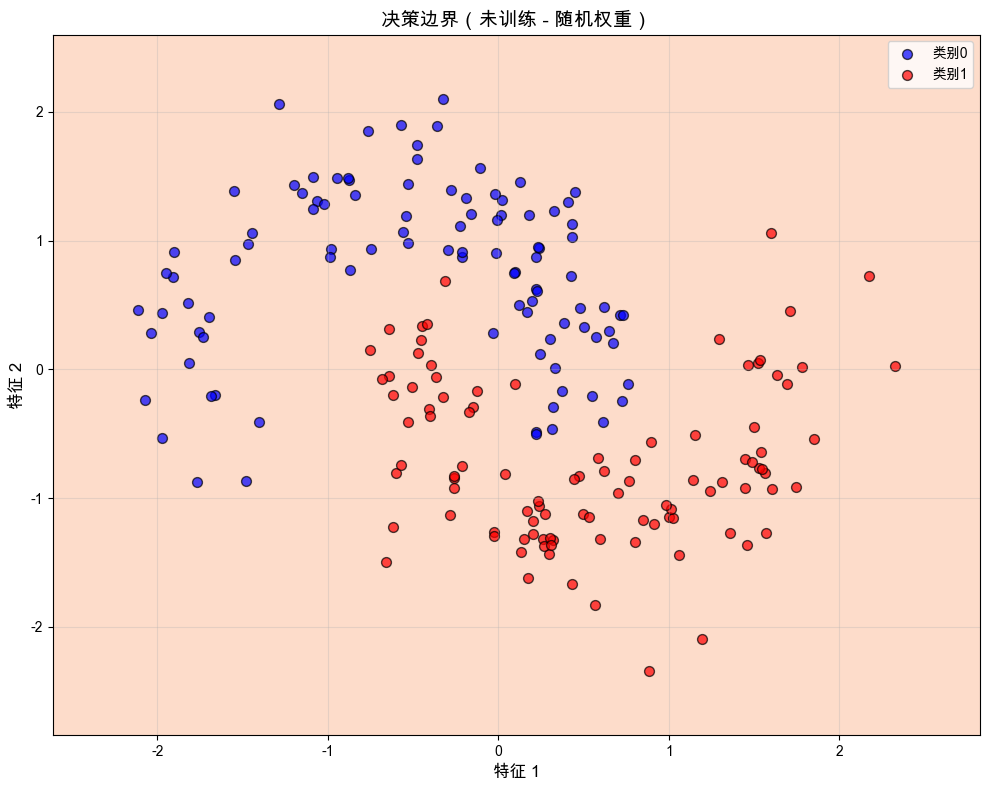

In [9]:
# 1. 数据准备
print("="*60)
print("实战项目：月亮数据集分类")
print("="*60)

# 生成数据
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 标准化（重要！）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"\n训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")
print(f"类别分布: 类别0={np.sum(y_train == 0)}, 类别1={np.sum(y_train == 1)}")

# 2. 构建网络
print("\n" + "-"*60)
print("构建MLP网络")
print("-"*60)

# 网络结构：2 → 16 → 8 → 2
mlp_project = MLP(
    layer_sizes=[2, 16, 8, 2],  # 2层隐藏层
    activation='relu',
    output_activation='softmax',
    random_state=42
)

# 3. 前向传播（使用随机初始化的权重）
print("\n" + "-"*60)
print("前向传播（未训练）")
print("-"*60)

# 在训练集上预测
train_predictions = mlp_project.predict(X_train)
train_accuracy = np.mean(train_predictions == y_train)

# 在测试集上预测
test_predictions = mlp_project.predict(X_test)
test_accuracy = np.mean(test_predictions == y_test)

print(f"\n训练集准确率（未训练）: {train_accuracy:.4f}")
print(f"测试集准确率（未训练）: {test_accuracy:.4f}")
print("\n注意：由于权重是随机初始化的，准确率约为50%（随机猜测）")
print("在下一章，我们将学习反向传播来训练这个网络！")

# 4. 可视化决策边界（未训练）
def plot_decision_boundary(model, X, y, title):
    """
    可视化决策边界
    """
    # 创建网格
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # 在网格上预测
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 绘制
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', s=50, 
                label='类别0', edgecolors='k', alpha=0.7)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', s=50, 
                label='类别1', edgecolors='k', alpha=0.7)
    plt.xlabel('特征 1', fontsize=12)
    plt.ylabel('特征 2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_decision_boundary(mlp_project, X_test, y_test, 
                       '决策边界（未训练 - 随机权重）')

---

## 8. 本章小结

### 核心概念

1. **多层网络的必要性**
   - 单层网络只能线性分类
   - 隐藏层提供**特征变换**能力
   - 多层 = 更复杂的决策边界

2. **前向传播**
   - 数学公式：$\mathbf{h}^{(l)} = \sigma(W^{(l)} \mathbf{h}^{(l-1)} + \mathbf{b}^{(l)})$
   - 矩阵形式：$H^{(l)} = \sigma(H^{(l-1)} W^{(l)T} + \mathbf{b}^{(l)})$
   - 逐层计算，前一层的输出是后一层的输入

3. **权重初始化**
   - 不能全0：对称性问题
   - Xavier：适用于Sigmoid/Tanh
   - He：适用于ReLU
   - 目标：保持激活值方差稳定

4. **隐藏层的作用**
   - 自动学习特征表示
   - 将数据投影到更易分类的空间
   - 深度 ≈ 抽象层次

### 实现要点

```python
# 前向传播伪代码
A = X  # 输入
for layer in range(n_layers - 1):
    Z = A @ W[layer].T + b[layer]  # 线性
    A = activation(Z)              # 激活
output = softmax(A @ W_out.T + b_out)  # 输出层
```

### 下一章预告

在第4章，我们将学习：
- **反向传播算法**：如何计算梯度
- **梯度下降**：如何更新权重
- **训练循环**：完整的训练流程
- **实战**：训练我们的MLP并达到高准确率

---

## 9. 练习题

### 练习1：修改网络结构

创建一个4层网络（2个隐藏层），对圆形数据集进行前向传播：

In [ ]:
# 生成圆形数据集
X_circles, y_circles = make_circles(n_samples=500, noise=0.1, factor=0.5, random_state=42)

# TODO: 创建一个网络 [2, 20, 10, 2]
# mlp_ex1 = ...

# TODO: 进行前向传播并可视化决策边界
# ...

### 练习2：对比不同激活函数

分别使用Sigmoid、Tanh、ReLU作为隐藏层激活函数，观察隐藏层输出的差异：

In [ ]:
# TODO: 创建3个网络，分别使用不同的激活函数
# mlp_sigmoid = MLP([2, 10, 2], activation='sigmoid', ...)
# mlp_tanh = ...
# mlp_relu = ...

# TODO: 对比它们在相同数据上的隐藏层输出分布
# ...

### 练习3：深度网络的梯度消失

创建一个10层的深度网络，观察使用Sigmoid激活函数时的梯度消失现象：

In [ ]:
# TODO: 创建一个深度网络（10层）
# deep_net = MLP([10, 100, 100, 100, ..., 2], activation='sigmoid', ...)

# TODO: 测试前向传播，绘制每层激活值的标准差
# ...

### 练习4：可视化权重矩阵

可视化第一层权重矩阵，观察每个神经元"关注"的输入特征：

In [ ]:
# TODO: 创建一个网络并获取第一层权重
# mlp = MLP([2, 8, 2], ...)
# W1 = mlp.weights[0]  # shape: (8, 2)

# TODO: 使用热图可视化权重
# plt.imshow(W1, cmap='coolwarm', aspect='auto')
# ...

### 练习5：理解题

回答以下问题：

1. 为什么增加隐藏层可以提高模型的表达能力？
2. 如果所有权重初始化为相同的值（如0.5），会有什么问题？
3. Xavier和He初始化的核心区别是什么？
4. 如果使用ReLU激活函数，但用Xavier初始化，会有什么影响？
5. 在前向传播中，为什么要存储中间层的激活值？

---

## 参考答案提示

<details>
<summary>点击查看练习1提示</summary>

```python
mlp_ex1 = MLP(layer_sizes=[2, 20, 10, 2], 
              activation='relu',
              output_activation='softmax',
              random_state=42)

scaler = StandardScaler()
X_circles_scaled = scaler.fit_transform(X_circles)

plot_decision_boundary(mlp_ex1, X_circles_scaled, y_circles, 
                       '圆形数据集 - 未训练')
```
</details>

<details>
<summary>点击查看练习5答案</summary>

1. 隐藏层提供非线性特征变换，增加模型的表达能力
2. 对称性问题：所有神经元计算相同的输出和梯度
3. He初始化考虑了ReLU会"杀死"一半神经元的特性
4. 可能导致激活值方差衰减，梯度变小
5. 反向传播需要用到这些值来计算梯度
</details>

---

**下一章：** [04_backpropagation_implementation.ipynb](04_backpropagation_implementation.ipynb) - 反向传播实现
